## Notebook Description
### Model Five
This notebook is dedicated to my fifth model, which uses data from `engineered_data` folder. The model runs the `title_merge` column through the `CountVectorize`, then using a `FeatureUnion` joins the Feature Engineered columns before running the entire dataframe through a `Random Forest` model. Resulting in an Accuracy Score of 0.922. This is my second best model and used in the presentation.

In [48]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import FunctionTransformer

In [49]:
df = pd.read_csv('../engineered_data/engineered_data_merged_columns.csv')
df.head()

,subreddit,created_utc,title_merge,title_sentiment_neg,title_sentiment_neu,title_sentiment_pos,title_sentiment_compound,title_length,title_word_count,capitalized_letters_in_title,sentences_in_title
0,backpacking,1646011972,"Where to backpack 4 nights in Utah, Arizona, o...",0.000,0.804,0.196,0.9127,315,60,16,4
1,backpacking,1646007041,"Peace Walls, Belfast",0.000,0.364,0.636,0.5423,21,4,3,0
2,backpacking,1646005307,How To Mount Snowshoes On Osprey Talon 22 Back...,0.000,0.760,0.240,0.9282,247,45,11,5
3,backpacking,1646004876,Bringing dog to Kearsarge pass? [removed],0.000,1.000,0.000,0.0000,41,6,2,1
4,backpacking,1646000495,Mid 30s short trip to Thailand - Bangkok &amp;...,0.024,0.787,0.189,0.9786,839,162,32,11


#### Baseline Model

In [50]:
# Baseline model
# Need my model to be better than .50

df['subreddit'].value_counts(normalize=True)

ultrarunning    0.500125
backpacking     0.499875
Name: subreddit, dtype: float64

#### Set Up Target Variable

In [51]:
df['subreddit'] = df['subreddit'].replace({'ultrarunning': 0, 'backpacking': 1})
df.head()

,subreddit,created_utc,title_merge,title_sentiment_neg,title_sentiment_neu,title_sentiment_pos,title_sentiment_compound,title_length,title_word_count,capitalized_letters_in_title,sentences_in_title
0,1,1646011972,"Where to backpack 4 nights in Utah, Arizona, o...",0.000,0.804,0.196,0.9127,315,60,16,4
1,1,1646007041,"Peace Walls, Belfast",0.000,0.364,0.636,0.5423,21,4,3,0
2,1,1646005307,How To Mount Snowshoes On Osprey Talon 22 Back...,0.000,0.760,0.240,0.9282,247,45,11,5
3,1,1646004876,Bringing dog to Kearsarge pass? [removed],0.000,1.000,0.000,0.0000,41,6,2,1
4,1,1646000495,Mid 30s short trip to Thailand - Bangkok &amp;...,0.024,0.787,0.189,0.9786,839,162,32,11


In [52]:
# Create X and Y for Random Forest

X = df.drop(columns=['subreddit'])
y = df['subreddit']

In [53]:
# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Using Feature Union to utilize Feature Engineered columns in Pipeline

The following steps allow for `CountVectorizing` the `title_merge` column, while also passing in the feature engineered columns to the `Random Forest` model. Ultimately, a nested pipeline allows for this. Indexing into this nested relationship to tune hyperparameters can be seen with strings such as `feats__vect_pipe__vect__binary` in the `params_grid` dictionary

In [54]:
def get_title(df):
    return df['title_merge']

get_title_transformer = FunctionTransformer(get_title, validate=False)

In [55]:
def get_other_columns(df):
    return df[['title_sentiment_compound', 'title_length', 'title_word_count',
           'capitalized_letters_in_title', 'sentences_in_title']]

get_columns_transformer = FunctionTransformer(get_other_columns, validate=False)

In [56]:
pipe_cv = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])

In [57]:
pipe_model = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', pipe_cv),
        ('other_cols', get_columns_transformer)
    ])),
    ('rf', RandomForestClassifier())
])

In [58]:
param_grid = {
    'feats__vect_pipe__vect__binary': [True, False],
    'rf__n_estimators': [75, 100, 125],
    'rf__max_depth': [None, 3, 4, 5],
    'rf__max_features': ['auto', 3, 4, 5]
}
gs = GridSearchCV(pipe_model,
                  param_grid=param_grid,
                  verbose=1,
                  scoring='accuracy'
                 )
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits
0.9149721758486367


{'feats__vect_pipe__vect__binary': False,
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__n_estimators': 125}

### Evaluations

In [59]:
gs.score(X_train, y_train)

1.0

In [60]:
gs.score(X_test, y_test)

0.907

#### Predictions

In [61]:
preds = gs.predict(X_test)
preds[:10]

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

#### Model Evaluation

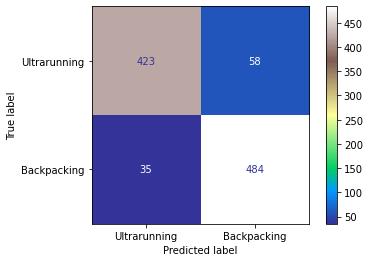

In [62]:
plot_confusion_matrix(gs, X_test, y_test, cmap='terrain', display_labels=['Ultrarunning', 'Backpacking'])
plt.savefig("../graphics/model_five_rf_confusion_matrix.jpg", bbox_inches="tight", dpi=100); #save as jpg

In [63]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

print(f'TN = {tn}')
print(f'FP = {fp}')
print(f'FN = {fn}')
print(f'TP = {tp}')

TN = 423
FP = 58
FN = 35
TP = 484


In [64]:
metrics.accuracy_score(y_test, preds)

0.907

In [65]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       481
           1       0.89      0.93      0.91       519

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



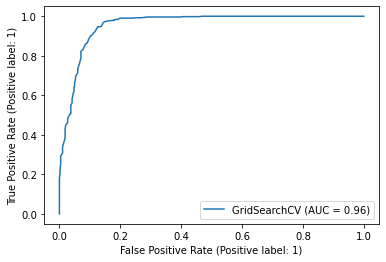

In [66]:
plot_roc_curve(gs, X_test, y_test)
plt.savefig("../graphics/model_five_rf_roc_curve.jpg", bbox_inches="tight", dpi=100); #save as jpg;

### Coefficients

In [67]:
coef = gs.best_estimator_._final_estimator.feature_importances_ # get coefficients
features = gs.best_estimator_.named_steps['feats'].transformer_list[0][1].named_steps['vect'].get_feature_names() #get feature names
zipped = zip(coef, features) #zip them together
lst = list(zipped) #turn zip object into a list
coef_df = pd.DataFrame(lst) # turn list into a df

In [68]:
coef_df.sort_values(by=0, ascending=False).head(10)

,0,1
11418,0.037035,running
11405,0.024550,run
2156,0.022007,backpacking
13866,0.021372,ultra
13592,0.015926,training
10661,0.015761,race
13721,0.008907,trip
882,0.008601,50
895,0.008327,50k
8644,0.006804,mile


In [69]:
top_ten_pos_class = coef_df.sort_values(by=0, ascending=True).tail(10)
top_ten_pos_class

,0,1
8644,0.006804,mile
895,0.008327,50k
882,0.008601,50
13721,0.008907,trip
10661,0.015761,race
13592,0.015926,training
13866,0.021372,ultra
2156,0.022007,backpacking
11405,0.024550,run
11418,0.037035,running


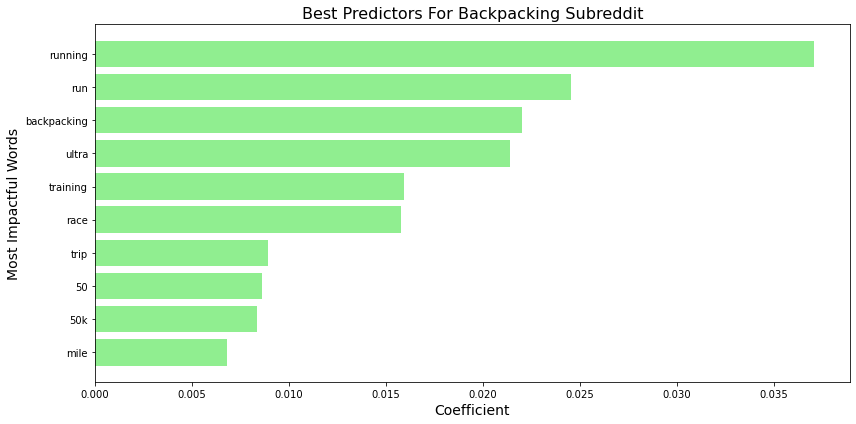

In [70]:
plt.figure(figsize=(12,6))
best_pred_sust = top_ten_pos_class.sort_values(by=0, ascending=False).head(15)
best_pred_sust = top_ten_pos_class.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color ='lightgreen')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For Backpacking Subreddit', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("../graphics/model_five_rf_Top10_backpacking_coef.jpg", bbox_inches="tight", dpi=100); #save as jpg;

In [71]:
top_ten_neg_class = coef_df.sort_values(by=0, ascending=False).head(10)
top_ten_neg_class

,0,1
11418,0.037035,running
11405,0.024550,run
2156,0.022007,backpacking
13866,0.021372,ultra
13592,0.015926,training
10661,0.015761,race
13721,0.008907,trip
882,0.008601,50
895,0.008327,50k
8644,0.006804,mile


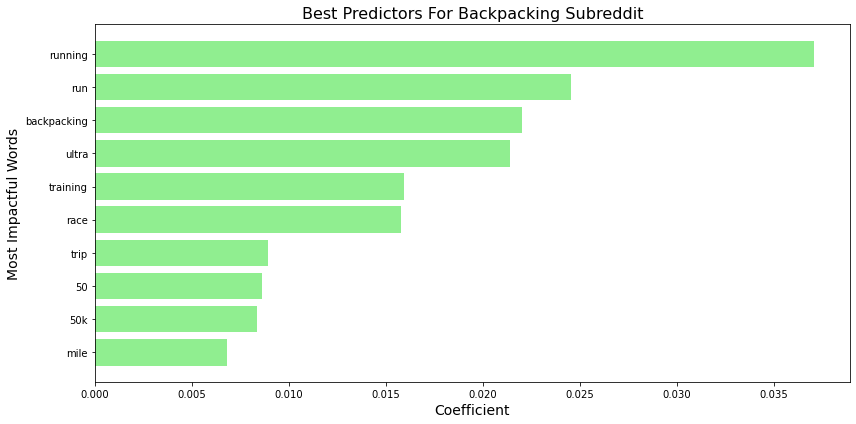

In [72]:
plt.figure(figsize=(12,6))
best_pred_sust = top_ten_neg_class.sort_values(by=0, ascending=False).head(15)
best_pred_sust = top_ten_neg_class.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color ='lightgreen')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For Backpacking Subreddit', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("../graphics/model_five_rf_Top10_ultrarunning_coef.jpg", bbox_inches="tight", dpi=100); #save as jpg;

### Analyzing Misclassified Predictions

In [73]:
misclassified = X_test[y_test != preds]

misclass_subreddit = pd.merge(misclassified, df['subreddit'], left_index=True, right_index=True)

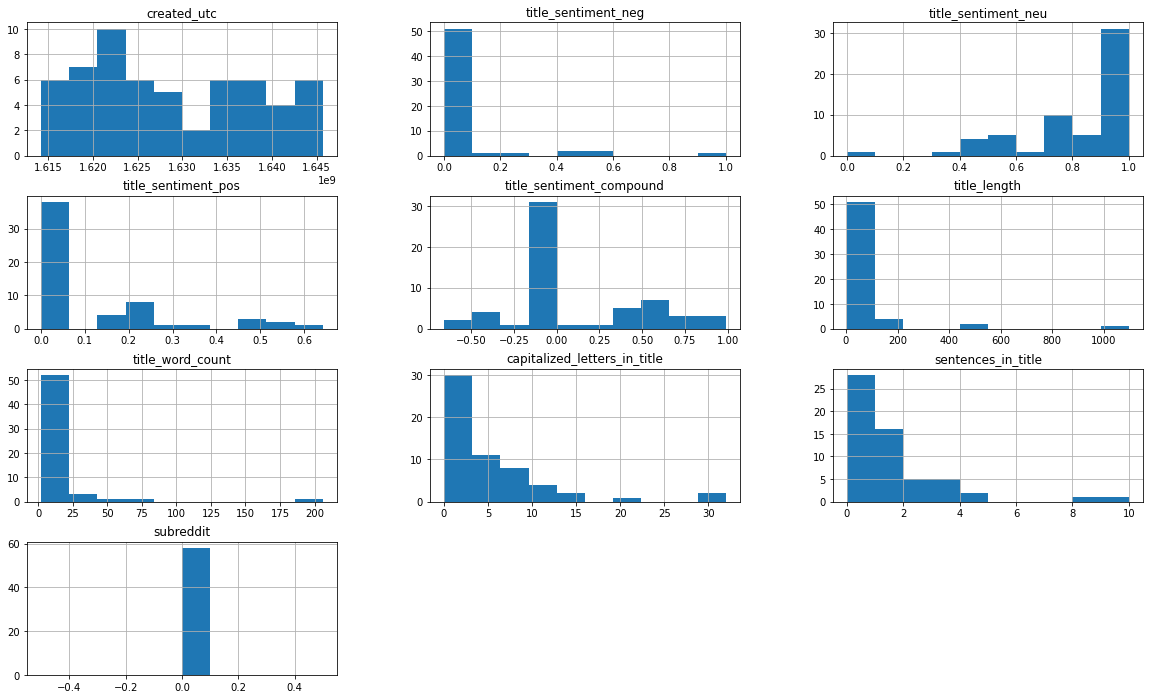

In [74]:
# Looking at the distribution of posts by feature from the Ultrarunning subreddit that were misclassified

ultrarunning_misclassified = misclass_subreddit[misclass_subreddit['subreddit'] == 0]
ultrarunning_misclassified.hist(figsize=(20,12));

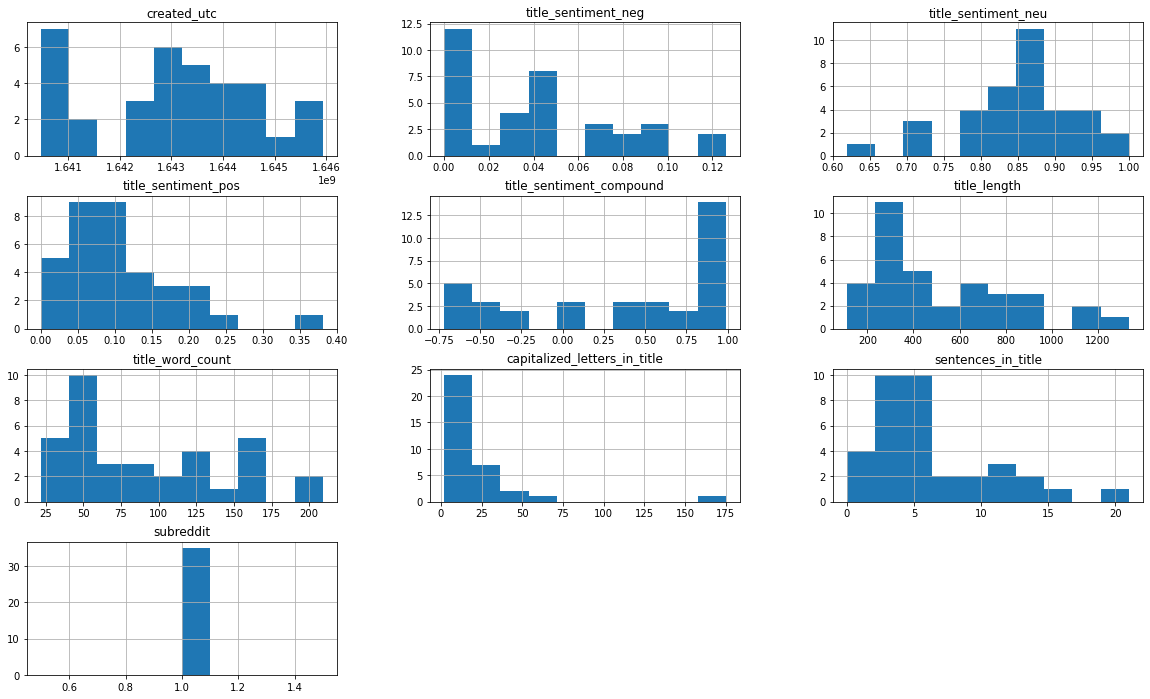

In [75]:
# Looking at the distribution of posts by feature from the Backpacking subreddit that were misclassified

backpacking_misclassified = misclass_subreddit[misclass_subreddit['subreddit'] == 1]
backpacking_misclassified.hist(figsize=(20,12));